# **Sustainable Development Goals (SDGs) Classifier**

![](https://www.idsa.in/system/files/sdg-un-banner.jpg)

### <a id="class_balance"><strong>Importing Libraries and Dataset</strong></a>

In [1]:
# libraries to manipulate data/dataset
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

# text/article cleaning package
import texthero as hero
import re

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud

# NLP labraries
import nltk
from nltk import stem
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer


# sklearn libraries
import sklearn
# metrics
from sklearn import metrics
# utility
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
# model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

# tensor & keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import models
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout


# other libraries
import pycountry

import warnings
warnings.filterwarnings("ignore")

### <a id="class_balance"><strong>Importing Dataset</strong></a>

In [2]:
def import_dataset(path: str) -> pd.DataFrame:
    """
    Data read_csvtion, importing `csv` file only
    Args:
        path: string like `file` address in the directory
    Return:
        df: (Dataframe) output imported csv file as pandas Dataframe
    """
    train_df = pd.read_csv(path, sep='\t')
    display(train_df.head(3))
    return train_df

In [3]:
df = import_dataset('osdg-community-dataset-v21-09-30.csv')

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286


In [4]:
def clean_agreement(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function takes in a dataframe and filters out the rows with negative label higher than positive label
    '''
    rslt_df = df.loc[df['labels_negative'] < df['labels_positive']]
    display(f'orignal dataset had {df.shape[0]} and the new dataset reduce to {rslt_df.shape[0]}')
    return rslt_df

In [5]:
train_df = clean_agreement(df)

'orignal dataset had 32120 and the new dataset reduce to 25788'

In [6]:
def set_agreement_threshold(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function takes in the dataframe
    and filters the rows based on a threshold for the agreement score
    (We are using a threshold of 0.4)
    '''
    result_df = df.loc[df['agreement'] >= 0.4]
    display(f'orignal dataset had {df.shape[0]} and the new dataset reduce to {result_df.shape[0]}')
    return result_df

In [7]:
train_df = clean_agreement(train_df)

'orignal dataset had 25788 and the new dataset reduce to 25788'

### <a id="class_balance"><strong>Cleaning Text and Lemmatization data Column</strong></a>

In [8]:
def clean(texts_row: str) -> str:
    
    """Converts apostrophe suffixes to words, replace webpage links with url, annotate 
    hashtags and mentions, remove a selection of punctuation, and convert all words to lower case.
    Args:
        text: 'text' article or sentence to be cleaned
    Returns:
        clean_text: clean text rid of noise 
    """
    text_hyp = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|\
                      (?:%[0-9a-fA-F][0-9a-fA-F]))+', '', texts_row)
    texts = hero.clean(pd.Series(text_hyp))[0]
    texts_split = texts.split()
    stops = set(stopwords.words("english"))
    clean_text = ' '.join([t for t in texts_split if t not in stops and len(t)>2]) 
#     text_hyp = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|\
#                       (?:%[0-9a-fA-F][0-9a-fA-F]))+', '', texts_row)
#     texts = re.sub(r'[^a-zA-Z ]', '', text_hyp).lower()
#     texts_split = texts.split()
#     stops = set(stopwords.words("english"))
#     clean_text = ' '.join([t for t in texts_split if t not in stops and len(t)>2]) 
    return clean_text

In [9]:
# Cleaning the text/article column
train_df['clean_text'] = train_df['text'].apply(clean)
train_df.head(3)

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement,clean_text
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000,gender perspective paulgaard points labour mar...
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286,average figure also masks large differences ac...
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333,extent akin corruption difficult assess govern...


In [10]:
# initializing lemmatization
lemmatizer = WordNetLemmatizer()

In [11]:
def lemma_tagging(row: str, lemma: stem=lemmatizer) -> str:
    
    """Tokenize and lemmatize text.
    Args:
        text (String): sentence containing 'text' to tokenize and tag with part of speech
    Returns:
        text (String): sentence with converted 'text' into lemmatized word(s)  
    """ 
    
    row_split = row.split()
    pos_tags = nltk.tag.pos_tag(row_split)
    compile_corpus = []
    for word, tag in pos_tags:
        if tag[0] == ('J'):
            compile_corpus.append((word, wordnet.ADJ))

        elif tag[0] ==('V'):
            compile_corpus.append((word, wordnet.VERB))

        elif tag[0] == ('N'):
            compile_corpus.append((word, wordnet.NOUN))

        elif tag[0] == ('R'):
            compile_corpus.append((word, wordnet.ADV))

        else:
            compile_corpus.append((word, wordnet.NOUN))
            
    return ' '.join([lemma.lemmatize(word, tag) for word, tag in compile_corpus])

In [12]:
train_df['lemma_text'] = train_df['clean_text'].apply(lemma_tagging)
train_df.head(3)

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement,clean_text,lemma_text
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000,gender perspective paulgaard points labour mar...,gender perspective paulgaard point labour mark...
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286,average figure also masks large differences ac...,average figure also mask large difference acro...
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333,extent akin corruption difficult assess govern...,extent akin corruption difficult assess govern...


### <a id="class_balance"><strong>E.D.A.</strong></a>

#### Target Distribution (Insight into data balancing)

In [13]:
def target_distribution(df: pd.DataFrame, target_label: dict) -> pd.DataFrame:
    """
    
    """
    df['SDG_Labels'] = df['sdg'].map(sdgLables)
    count = df.groupby("SDG_Labels").count()["text"].reset_index()
#     count.style.background_gradient(cmap="Purples")
    
    # Declare a figure with a custom size
    fig = plt.figure(figsize=(12, 8))

    # labels and size for the classes
    labels, sizes = target_label.values(), count.sort_index()['text']

    # Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90) 
    plt.show()
    print("See distribution of messages per sdg : ")
    return count.sort_values('text', ascending=False).style.background_gradient(cmap="Purples")

In [14]:
# creating a dictionary for our target variable
sdgLables = {1: "No poverty", 2: "Zero Hunger", 3: "Good Health and well-being", 4: "Quality Education",
             5: "Gender equality", 6: "Clean water and sanitation", 7: "Affordable and clean energy",
             9: "Industry, Innovation and Infrustructure", 8: "Decent work and economic growth",
             10: "Reduced Inequality", 13: "Climate Action", 11: "Sustainable cites and communities",
             12: "Responsible consumption and production", 14: "life below water", 15: "Life on land"}
 

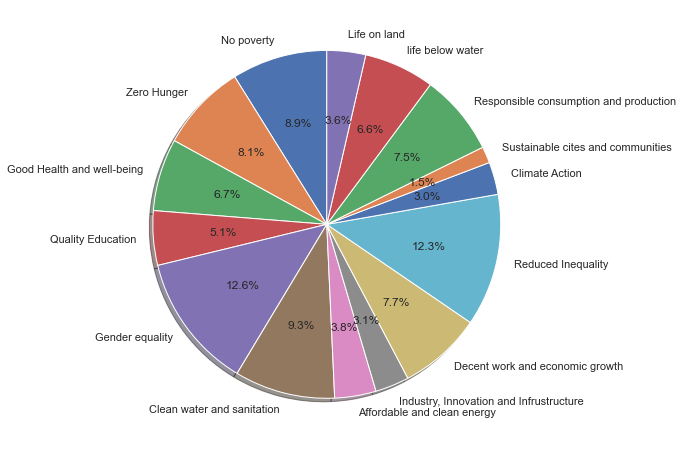

See distribution of messages per sdg : 


,SDG_Labels,text
4,Gender equality,3245
9,Quality Education,3174
5,Good Health and well-being,2410
0,Affordable and clean energy,2290
1,Clean water and sanitation,2097
8,No poverty,1996
12,Sustainable cites and communities,1943
2,Climate Action,1734
13,Zero Hunger,1690
3,Decent work and economic growth,1305


In [15]:
target_distribution(train_df, sdgLables)

#### WordCloud (Insight into the `text` important keywords)

In [16]:
def wordcloud(df: pd.DataFrame) -> plt.show:
    """
    
    """
    # Most occurring words of the train set
    words_train = " ".join([word for word in df['clean_text']])
    wordcloud = WordCloud(background_color='black', width=3200, 
                          height=1700, random_state=46).generate(words_train)
    # Displaying the word cloud image:
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    return plt.show()

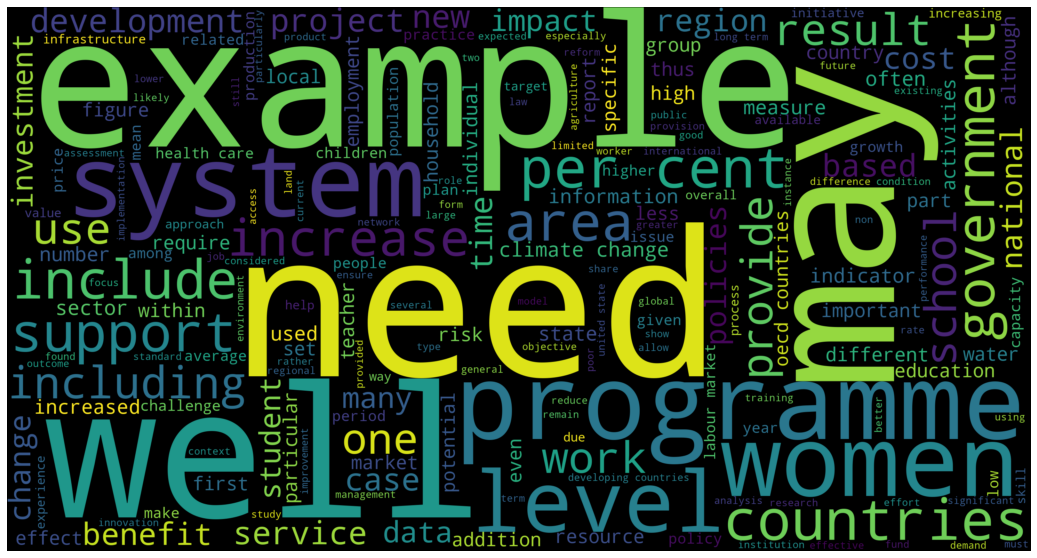

In [17]:
wordcloud(train_df)

#### Insight on Countries Involved

In [18]:
def creating_country(text: str) -> str:
    """
    This function helps to extract a country from each of the text and returns the country
    """
        # importing countries from pycountries package   
    country_list = []
    for country in pycountry.countries:
        country_list.append(country.name)
    country_list = list(map(lambda x: x.lower(),country_list))
    
    text_set = set(text.split())
    country_set = set(country_list)
    country_ext = ' '.join([t for t in text_set if t in country_set])
    return country_ext


In [19]:
# Implementation of the creating_country function
train_df['country'] = train_df.clean_text.apply(creating_country)

In [20]:
def country_extract(df: pd.DataFrame, country_num: int=10) -> plt.show:
    """
    Args:
        df: DataFrame where we want to extract countries from
        country: (integer) how many country do want to see there distribution
    return:
        a visual of countries and there frequency
    """
    
    temp_df = df['country'].value_counts().to_frame().sort_values('country', ascending=False)
    temp_df.drop('', inplace=True)
    temp_df = temp_df[:country_num]
    
    # A visual check of the distribution of the sdg between the classes
    fig, ax1 = plt.subplots(figsize=(country_num,8))
    graph = sns.barplot(ax=ax1, x=temp_df.index, y='country', data=temp_df)
    graph.set_xticklabels(graph.get_xticklabels())
    sns.set(font_scale=1.5)
    plt.title("Distribution of the countries")
    plt.ylabel('Frequency')
    plt.xlabel('Countries')
    plt.tick_params(axis='x', rotation=65)
    for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/3., height + 0.1,height)
    
    return plt.show()

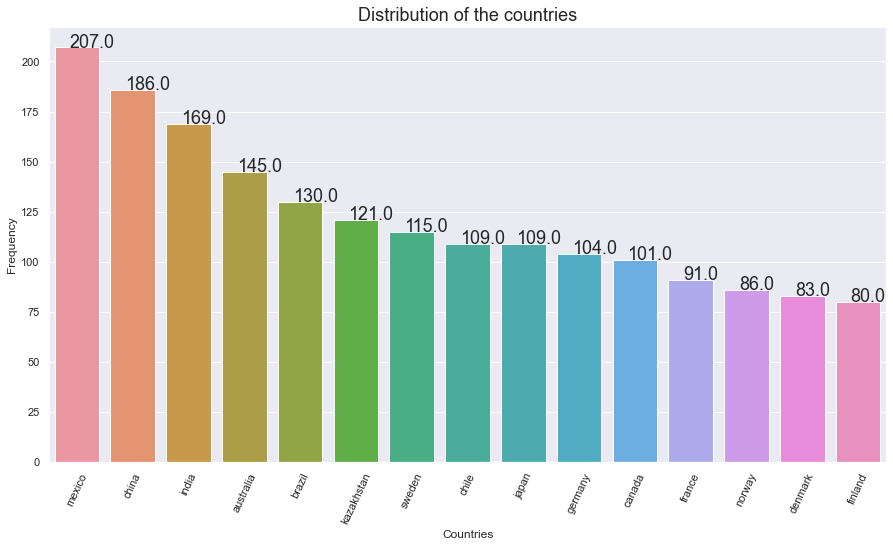

In [21]:
# visualizing the countries involvment distribution
country_extract(train_df, 15)

### <a id="class_balance"><strong>Working with balanced data</strong></a>

In [22]:
# Creating a funtion to balance the dataset
def data_balancing(df_input: pd.DataFrame, scaling: str="UpScaling") -> pd.DataFrame:
    """
        Dataset balancing for all target variable to be equal in frequency.
    Args:
        `df` (DataFrame): pd.Series containing the target variable
        `scaling`('DownScaling', 'UpScaling', 'BalanceScaling'); by default it will be `UpScale` 
        Data balancing will be done base on the assign instruction.   
    Return:
        df (DataFrame): dataframe with resample and balance dataset asper instruction on `scaling`
    """
    df = df_input.copy()
    if scaling == 'DownScaling':
        class_size = int(df.sdg.value_counts().min()) # setting the minimum size for each category in 'sdg'
    elif scaling == 'BalanceScaling':
        class_size = int(df.sdg.value_counts().mean()) # setting an average value for each category in 'sdg'
    else:
        class_size = int(df.sdg.value_counts().max()) # setting the maximum size for each category in 'sdg'

    target_size = df.sdg.value_counts() # getting category name and their size
    appended_target = [] # creating an empty list to append all category after resampling

    # Creating a for-loop to resample and append to a list
    for index, size in target_size.items():
        if size < class_size: # setting condition to check if to downsample or upsample
            temp_pd = resample(df[df['sdg']==index],
                              replace=True, # sample with replacement
                              n_samples=class_size, # match number in majority class
                              random_state=27)
        else:
            temp_pd = resample(df[df['sdg']==index],
                              replace=False, # sample with replacement (no need to duplicate observations)
                              n_samples=class_size, # match number in minority class
                              random_state=27)
    # Appending each category after resampling
        appended_target.append(temp_pd)
        
    # Creating a new dataframe and viewing
    df_resampled = pd.concat(appended_target, axis=0)
    # Class with there new resampled sizes
    target_new_size = df_resampled.sdg.value_counts()
    
    # ploting the old and new graph frequency
    ax = target_size.plot(kind='bar')
    target_new_size.plot(kind='bar', title='Count (target)', 
                         ax=ax,color='orange', alpha=0.5);
    plt.xticks(range(len(target_size)), target_size.index)
    plt.ylabel("# of observations")
    plt.legend(['original','resampled'])
    plt.show()
    return df_resampled

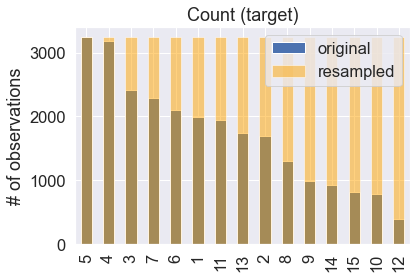

In [23]:
# calling a function to resample the dataset
df_train_resample = data_balancing(train_df)

### <a id="class_balance"><strong>Data Spliting & Vectorization</strong></a>

In [26]:
def train_test(df: pd.DataFrame) -> tuple:
    """
    Args: df (DataFrame) including th predictor (X) and the target (y)
    Return: Split data to target (y) and features (X)
    """
    X = df['lemma_text']
    y = (np.array(df['sdg']))
    
    # Here we split data to training and testing parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [27]:
# spliting data to training and testing parts
X_train, X_test, y_train, y_test = train_test(df_train_resample)

In [28]:
def vect(X_train, X_test, vect_keyword= "TfidfVectorizer", min_word=None,
         max_features = 20000, ngram_range=(1, 2)) -> tuple:
    """
    Args:
        (X_train, X_test); Train and Test set (DataFrame)
        vect_keyword (vectorizer); choose between "TfidfVectorizer", "CountVectorizer"
        
        max_features : int, default=20000
 |      If not None, build a vocabulary that only consider the top
 |      max_features ordered by term frequency across the corpus.
 
        min_df : float or int, default=None
 |      When building the vocabulary ignore terms that have a document
 |      frequency strictly lower than the given threshold. This value is also
 |      called cut-off in the literature.
 
    Return:
        X_train (np_array); vectorize train set,
        X_test (np_array); vectorize test set &
        vectorizer (); which can be use to transform other text/article
    """
    # converting each word in the dataset into features
    if vect_keyword == "CountVectorizer":
        vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    else:
        vectorizer = TfidfVectorizer(max_features=max_features, sublinear_tf=True, ngram_range=ngram_range)

    #NB. fit to train and transform the test data to avoid data leakage
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()
    
    return X_train, X_test, vectorizer

In [29]:
# Vectorizing data for training and testing parts
X_train, X_test, vectorizer = vect(X_train, X_test)

### <a id="class_balance"><strong>Model & Model Performance</strong></a>

In [30]:
def modelling(model: sklearn, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test) -> sklearn:
    
    """
    Args:
        X_train, X_test are the predictor variables and  y_train, y_test are the target variable
        model' choosen sklearn classifier model
    Return:
        model (fitted model)
    """
    
    model_name = str(type(model)).split('.')[-1][:-2]
       
    print ('Fitting {:s} model...'.format(model_name))
    run_time = %timeit -q -o model.fit(X_train, y_train)

    print ('... predicting')
    y_pred = model.predict(X_train)   
    y_pred_test = model.predict(X_test)

    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='weighted')
    recall    = metrics.recall_score(y_train, y_pred, average='weighted')

    f1        = metrics.f1_score(y_train, y_pred, average='weighted')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average='weighted')  
    print(metrics.classification_report(y_test, y_pred_test, target_names=sdgLables.values()))

    # Save the results to pandas DataFrame   
    confusion= metrics.confusion_matrix(y_test, y_pred_test)
    confusion_df = pd.DataFrame(confusion, index = sdgLables.values(), columns = sdgLables.values())
    
    display(pd.DataFrame.from_dict({'model name': model_name, 'accuracy': accuracy, 'precision': precision, 
             'recall': recall, 'f1_train': f1, 'f1_test': f1_test, 'run_time': run_time.best},
           orient ='index', columns=['Score']).T)

    # plotting the confusion matrix using heatmap
    plt.figure(figsize=(14,6))
    sns.heatmap(confusion_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.tick_params(axis='x', rotation=75)
    plt.show()

    return model

Fitting LinearSVC model...
... predicting
... scoring
                                         precision    recall  f1-score   support

                             No poverty       0.95      0.94      0.94       638
                            Zero Hunger       0.96      0.97      0.97       661
             Good Health and well-being       0.96      0.97      0.96       655
                      Quality Education       0.97      0.97      0.97       659
                        Gender equality       0.96      0.91      0.94       656
             Clean water and sanitation       0.97      0.97      0.97       633
            Affordable and clean energy       0.96      0.96      0.96       615
Industry, Innovation and Infrustructure       0.95      0.95      0.95       690
        Decent work and economic growth       0.96      0.99      0.97       646
                     Reduced Inequality       0.97      0.99      0.98       663
                         Climate Action       0.96    

,model name,accuracy,precision,recall,f1_train,f1_test,run_time
Score,LinearSVC,1.0,1.0,1.0,1.0,0.966627,23.470377


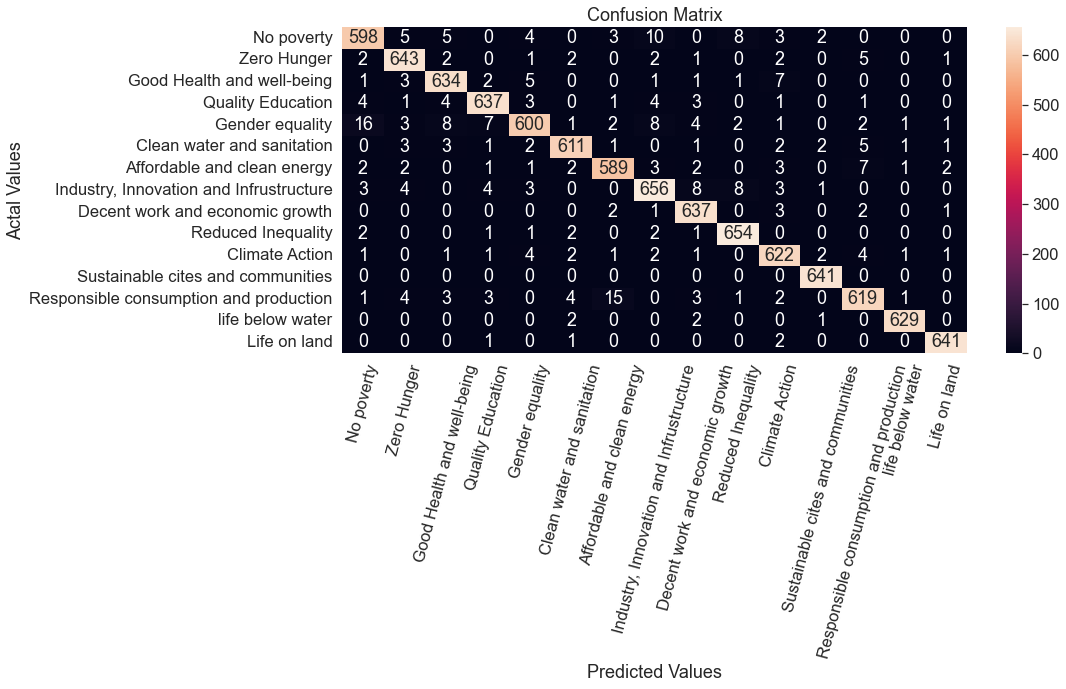

In [31]:
model =  LinearSVC(C=10, loss='squared_hinge', penalty='l2')
chk = modelling(model)

### <a id="class_balance"><strong>MultiLabeling with Nueral Network</strong></a>

In [35]:
def create_model(input_shape: int=None, lyrs=2, num_classes=16, act='relu', dr=0.2, 
                 learning_rate=1e-3, loss: str='sparse_categorical_crossentropy') -> keras:
    """
    Args:
        
    Return:
        
    """
    model = keras.models.Sequential()
    input_shape = X_train.shape[1:]
    
    # set random seed for reproducibility
    tf.random.set_seed(42)
    
    # create first/hidden layer
    model.add(Dropout(rate=dr, input_shape=input_shape))
    model.add(Dense(128, activation=act))
    
    # create additional hidden layers
    for i in range(1,lyrs):
        model.add(Dense(64, activation=act))
    
    # create output layer
    model.add(Dense(num_classes, activation='sigmoid'))  # output layer
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [37]:
# creating the model
input_shape = X_train.shape[1:]
model = create_model(input_shape=input_shape)

In [38]:
def model_fit(model: keras=model, epochs:int=200, batch_size:int=128, X_train: np.array=X_train,
              y_train: np.array=y_train, X_test: np.array=X_test, y_test: np.array=y_test) ->keras:
    """
    
    """
    # Create callback for early stopping on validation loss. If the loss does
    # not decrease on two consecutive tries, stop training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

    # Train and validate model
    # To start training, call the model.fit method—the model is "fit" to the training data.
    # Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
                        verbose=1, batch_size=batch_size, callbacks=callbacks)
    
    display(model.summary())
    # Compare how the model performs on the validation dataset:
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    return model

In [39]:
# predicting with the fitted model
train_model = model_fit()

Epoch 1/200
305/305 [==============================] - 27s 85ms/step - loss: 1.1094 - accuracy: 0.7520 - val_loss: 0.3184 - val_accuracy: 0.9249
Epoch 2/200
305/305 [==============================] - 18s 60ms/step - loss: 0.1732 - accuracy: 0.9611 - val_loss: 0.1710 - val_accuracy: 0.9596
Epoch 3/200
305/305 [==============================] - 18s 60ms/step - loss: 0.0663 - accuracy: 0.9862 - val_loss: 0.1431 - val_accuracy: 0.9645
Epoch 4/200
305/305 [==============================] - 18s 59ms/step - loss: 0.0330 - accuracy: 0.9934 - val_loss: 0.1425 - val_accuracy: 0.9648
Epoch 5/200
305/305 [==============================] - 18s 60ms/step - loss: 0.0217 - accuracy: 0.9955 - val_loss: 0.1479 - val_accuracy: 0.9644
Epoch 6/200
305/305 [==============================] - 18s 58ms/step - loss: 0.0161 - accuracy: 0.9968 - val_loss: 0.1579 - val_accuracy: 0.9626
Epoch 7/200
305/305 [==============================] - 18s 58ms/step - loss: 0.0136 - accuracy: 0.9973 - val_loss: 0.1616 - val_ac

None

305/305 [==============================] - 2s 5ms/step - loss: 0.2180 - accuracy: 0.9628
Test loss: 0.2179778814315796
Test accuracy: 0.9628145694732666


In [125]:
def multilabel_hardCoding(df: pd.DataFrame, pred: np.array, sdglabel: dict, thres: float=0.5,
                          coln: str='multilabel_sdg',str_typ: bool=True,
                          list_typ: bool=None, dict_typ: bool=None) ->pd.DataFrame:
    """
    Args:
        df: DataFrame we are trying to make a prediction on
        pred: numpy array from model prediction (likely from nueral network)
        sdgLables: a dictionay contain all the name of the sdg goals and their designated number
        thres: a float to represent percentage cut-off for a valid prediction in `pred` array
        coln: a string to name the new column that would be created for `multilabe
    Return:
        df: DataFrame with multilabel additional column 
    """
    pred_list = []
    for x_1 in pred:
        result = np.where(x_1 >= thres)[0]
        count = 0
        for x_2 in result:
            count += x_1[x_2]
        count_list = []
        for x_3 in result:
            count_list.append(round(x_1[x_3]/count, 2))
        final_str = []
        final_list = []
        final_dict = {}
        for x_4, y in zip(result, count_list):
            if list_typ == True:
                final_list.append((sdgLables[x_4], str(y)))
            elif dict_typ == True:
                final_dict[sdgLables[x_4]] = str(y)
            else:
                final_str.append((f'{sdgLables[x_4]}: {str(y)}'))
        if final_str:
            pred_list.append(', '.join(final_str))
        elif final_list:
            pred_list.append(final_list)
        else:
            pred_list.append(final_dict)
        
    df[coln] = pred_list
    
    return df

In [126]:
# creatinga temp. dataframe for the multilabel testing
df_test = train_df[-6000:]
# vectorizing the test dataframe
test_vec = vectorizer.transform(df_test['lemma_text']).toarray()

In [127]:
# predicting for the created test dataframe
pred_test = train_model.predict(test_vec)

188/188 [==============================] - 1s 5ms/step


In [156]:
df_with_pred = multilabel_hardCoding(df_test[['text', 'SDG_Labels']] , pred_test, sdgLables)
df_with_pred.head(3)

,text,SDG_Labels,multilabel_sdg
24635,Regional differences in income inequalities ar...,No poverty,"No poverty: 0.26, Quality Education: 0.23, Gen..."
24636,"On balance, they suggest that trade is likely ...",Zero Hunger,Zero Hunger: 1.0
24637,The budget for evaluation activities also incr...,Quality Education,"Quality Education: 0.63, life below water: 0.37"


In [152]:
def single_text_pred(text: str, vect: TfidfVectorizer=vectorizer, model: sklearn=train_model, ) -> plt.show:
    """
    Args:
        text: (String) text/article to be predicted
        df: (DataFrame) to be use in vectorizing against transforming the `text`
        model: (best with Nueral Network) model to be use in actual text prediction
    Return:
        matplotlib visual displaying the proportion of each label of the text
    """
    #     
    clean_text = clean(text)
    lemma_text = lemma_tagging(clean_text)
    text_vec = [lemma_text]
    
    # vectorizing the test dataframe
    text_vec = vectorizer.transform(text_vec).toarray()

    # predicting for the text
    pred_text = train_model.predict(text_vec)
    
    # creating new dataFrame
    df_new = pd.DataFrame.from_dict({1: text}, orient='index', columns=['text'])
    # hardCoding multilabel in `dict` format
    df_final = multilabel_hardCoding(df_new, pred_text, sdgLables, dict_typ=True)
    multilabel_sdg = df_final.multilabel_sdg.iloc[0]
    
    # Declare a figure with a custom size
    fig = plt.figure(figsize=(10, 6))
    # labels and size for the classes
    labels, sizes = multilabel_sdg.keys(), [float(x) for x in multilabel_sdg.values()]
    # Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90) 
    
    print(f'The prediction for the text: "{text}" is->')
    return plt.show()

1/1 [==============================] - 0s 33ms/step
The prediction for the text: "The extent to which they are akin to corruption is difficult to assess. In 2005, the government implemented an anti-corruption campaign, which decreased the frequency of informal payments. The Ministry' of Health too has been taking steps to reduce corruption and fraud. In 2009, the European Healthcare Fraud and Corruption Network Excellence Award was granted to Mrs. Ewa Kopacz, then Minister of Health, for her anti-corruption and anti-fraud actions." is->


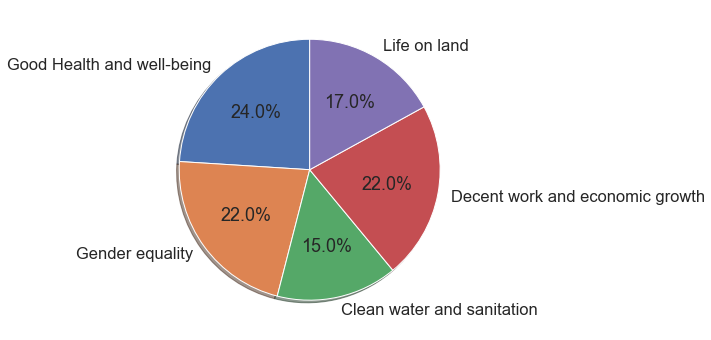

In [153]:
# making a single text/article prediction
single_text_pred(df.text.iloc[3], train_df, sdgLables)